# UJM - Master DSC/MLDM - Deep Learning - TP1a - pytorch version

## Help and documentation on Torch

From the page of torch: <https://pytorch.org>
In particular you will have access to some guides: <https://pytorch.org/tutorials/>
And the API where you can look for specific functions or functionalities <https://pytorch.org/docs/stable/index.html>

### Part 1

As a cold start, we begin by considering some generated data

First we take the packages for displaying elements and generating data, we will use sklearn

In [508]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [509]:
centers = [(0, -5), (0, 5), (5, 0)]
X, y = make_blobs(n_samples=1000, n_features=2, cluster_std=1.5, centers=centers)

In [510]:
print(X.shape)
print(y.shape)

(1000, 2)
(1000,)


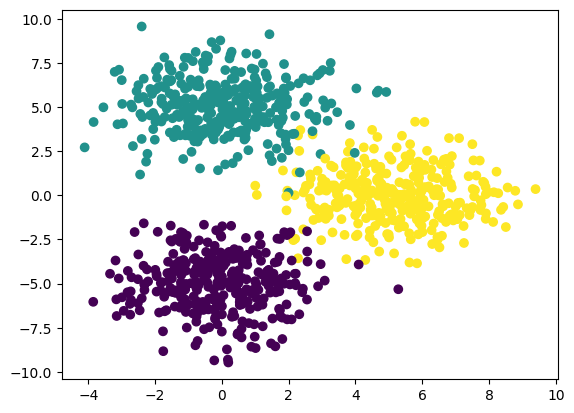

In [511]:
plt.scatter(X[:,0],X[:,1], c=y)
plt.show()

In [512]:
X[:10]

array([[-1.90121303,  7.26484669],
       [-0.48773408, -6.21783725],
       [ 4.29670028,  0.58078873],
       [ 7.39047864,  1.08207597],
       [-0.84580087, -2.90542292],
       [ 0.38175828,  6.60058876],
       [ 1.68159196, -5.33624845],
       [-1.20337886, -5.69112225],
       [ 2.19570721, -4.97038203],
       [-3.84080073,  4.15173281]])

In [513]:
y[:10]

array([1, 0, 2, 2, 0, 1, 0, 0, 0, 1])

**Note** that we skip the part of one hot encoding using to_categorical in keras, we just need to
pass the class index targets into the loss function and PyTorch will take care of the rest.

In [514]:
import torch
import torch.nn.functional as F
y_torch = torch.tensor(y)
X_torch = torch.tensor(X)
Y_torch = F.one_hot(y_torch, num_classes=3)

In [515]:
X_torch[:10]

tensor([[-1.9012,  7.2648],
        [-0.4877, -6.2178],
        [ 4.2967,  0.5808],
        [ 7.3905,  1.0821],
        [-0.8458, -2.9054],
        [ 0.3818,  6.6006],
        [ 1.6816, -5.3362],
        [-1.2034, -5.6911],
        [ 2.1957, -4.9704],
        [-3.8408,  4.1517]], dtype=torch.float64)

**Now** We prepare the data with a split into train/test with ration 2:1 using Sklearn train_test_split, random seed is initialized to 1

In [516]:
X_train, X_test, y_train, y_test=train_test_split(X_torch,y_torch,test_size=0.33,random_state=1)

In [517]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([670, 2])
torch.Size([330, 2])
torch.Size([670])
torch.Size([330])


**Note** We create a model with 3 layers, activations are ReLu and we add dropout regularizations. Last activation is softmax

In [518]:
def create_model ():
    
    return torch.nn.Sequential(
        torch.nn.Linear(2, 6),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(6, 6),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(6, 3),
        torch.nn.Softmax(dim=1)
    )


**Note** we now define the loss (crossentropy), the optimizer (adam) and the performance metrics, and we print the model

In [519]:
model = create_model()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), eps=1e-07) # we set eps to match Keras!

**Note** Now we print the summary of the network we just created.

In [520]:
from torchsummary import summary
input_shape = X_train.shape
summary(model, input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 670, 6]              18
              ReLU-2               [-1, 670, 6]               0
           Dropout-3               [-1, 670, 6]               0
            Linear-4               [-1, 670, 6]              42
              ReLU-5               [-1, 670, 6]               0
           Dropout-6               [-1, 670, 6]               0
            Linear-7               [-1, 670, 3]              21
           Softmax-8               [-1, 670, 3]               0
Total params: 81
Trainable params: 81
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 0.00
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


**Note** convert the numpy data into tensors and create a data loader
which creates and iterator of batches of data.

In [521]:
train_dataset = torch.utils.data.TensorDataset(X_train,y_train) # create your datset
test_dataset = torch.utils.data.TensorDataset(X_test,y_test) # create your datset

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                         shuffle=True, num_workers=0)

**Note** Now we define the two functions, one for training and another for testing the accuracy
of the trained network on test samples.

In [522]:
#Function to train the model with train dataset and print the training accuracy for every 10 batches.
def train(epochs, optimizer, model, trainloader, reg_type=None, reg_lambda=0.01):
  for epoch in range(epochs):  # loop over the dataset multiple times
    accuracy = 0.0
    total = 0.0
    running_loss = 0.0
    for i, data in enumerate(trainloader,0): #
        # zero the parameter gradients
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = loss_fn(outputs, labels)
        
        if reg_type == 'l1':
          l1_norm = sum(p.abs().sum() for p in model.parameters())
          loss += reg_lambda * l1_norm
          
        elif reg_type == 'l2':
          l2_norm = sum(p.pow(2).sum() for p in model.parameters())
          loss += reg_lambda * l2_norm
        
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
              
  model.eval()
  accuracy = 0.0
  total = 0.0
  
  with torch.no_grad():
    for data in trainloader:
          inputs, labels = data
          outputs = model(inputs.float())
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          accuracy += (predicted == labels).sum().item()
  accuracy = (100 * accuracy / total)
  return accuracy

# Function to test the model with the test dataset and print the accuracy for the test images
def test(model, testloader):

    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images.float())
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

**Note** we now display accuracy on train and test

In [523]:
train_acc = train(epochs=50, optimizer=optimizer, model=model, trainloader=trainloader)
test_acc = test(model=model, testloader=testloader)
print('training_accuracy:', train_acc)
print('testing_accuracy:', test_acc)

training_accuracy: 98.05970149253731
testing_accuracy: 99.0909090909091


**Note** if you fit again the model may continue to train

If you want to display the result every 10 epochs, you could use the following kind of loops
```
for i in range(5):
    model.fit(X_train, y_train, epochs=10, batch_size=64,verbose=0)
    _, train_acc = model.evaluate(X_train, y_train, batch_size=64)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=64)
    print('training_accuracy, epoch number ', i*10+ 10,' : ', train_acc)
    print('testing_accuracy, epoch number ', i*10+ 10,' : ', test_acc,'\n')
```

**Question**
Use this procedure to compare the behavior of different optimizers available on Pytorch, check this page
<https://pytorch.org/docs/stable/optim.html>
Try to compare the behavior of: SGD, RMSprop, Adam, Adadelta, Adagrad
Have a look to the available parameters

In [524]:
# optimzer_list = {
#     'SGD': torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
#     'RMSprop': torch.optim.RMSprop(model.parameters(), lr=0.01, momentum=0.9),
#     'Adam': torch.optim.Adam(model.parameters(), lr=0.01),
#     'Adadelta': torch.optim.Adadelta(model.parameters(), lr=0.01),
#     'Adagrad': torch.optim.Adagrad(model.parameters(), lr=0.01)
# }
    
model = create_model()
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_acc = train(epochs=50, optimizer=opt, model=model, trainloader=trainloader)
test_acc = test(model=model, testloader=testloader)
print('training_accuracy:', train_acc)
print('testing_accuracy:', test_acc)

training_accuracy: 97.61194029850746
testing_accuracy: 98.78787878787878


In [525]:
model = create_model()
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adadelta(model.parameters(), lr=1)

train_acc = train(epochs=50, optimizer=opt, model=model, trainloader=trainloader)
test_acc = test(model=model, testloader=testloader)
print('training_accuracy:', train_acc)
print('testing_accuracy:', test_acc)

training_accuracy: 98.35820895522389
testing_accuracy: 99.0909090909091


**Question** Using your favorite optimizer, try to change the architecture by simplifying or complexifying it, how the performance evolves?
Objective: Learn to add normalization layers, dropout, L1/L2 regularization.

In [526]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 3),
    torch.nn.Softmax(dim=1)
)
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adadelta(model.parameters(), lr=1)
train_acc = train(epochs=50, optimizer=opt, model=model, trainloader=trainloader)
test_acc = test(model=model, testloader=testloader)
print('\nbaseline (no normalization, dropout, regularization):')
print('training_accuracy:', train_acc)
print('testing_accuracy:', test_acc)


baseline (no normalization, dropout, regularization):
training_accuracy: 98.35820895522389
testing_accuracy: 99.0909090909091


In [527]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 6),
    torch.nn.LayerNorm(6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.LayerNorm(6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 3),
    torch.nn.Softmax(dim=1)
)
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adadelta(model.parameters(), lr=1)
train_acc = train(epochs=50, optimizer=opt, model=model, trainloader=trainloader)
test_acc = test(model=model, testloader=testloader)
print('\nAdd layer normalization:')
print('training_accuracy:', train_acc)
print('testing_accuracy:', test_acc)


Add layer normalization:
training_accuracy: 98.50746268656717
testing_accuracy: 99.0909090909091


In [528]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 6),
    torch.nn.LayerNorm(6),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(6, 6),
    torch.nn.LayerNorm(6),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(6, 3),
    torch.nn.Softmax(dim=1)
)
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adadelta(model.parameters(), lr=1)
train_acc = train(epochs=50, optimizer=opt, model=model, trainloader=trainloader)
test_acc = test(model=model, testloader=testloader)
print('\nAdd layer normalization + dropout:')
print('training_accuracy:', train_acc)
print('testing_accuracy:', test_acc)


Add layer normalization + dropout:
training_accuracy: 98.50746268656717
testing_accuracy: 99.0909090909091


In [529]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 6),
    torch.nn.LayerNorm(6),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(6, 6),
    torch.nn.LayerNorm(6),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(6, 3),
    torch.nn.Softmax(dim=1)
)
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adadelta(model.parameters(), lr=1)
train_acc = train(epochs=50, optimizer=opt, model=model, trainloader=trainloader, reg_type='l1', reg_lambda=0.1)
test_acc = test(model=model, testloader=testloader)
print('\nAdd layer normalization + dropout + l1 norm:')
print('training_accuracy:', train_acc)
print('testing_accuracy:', test_acc)


Add layer normalization + dropout + l1 norm:
training_accuracy: 34.02985074626866
testing_accuracy: 31.818181818181817


In [530]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 6),
    torch.nn.LayerNorm(6),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(6, 6),
    torch.nn.LayerNorm(6),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(6, 3),
    torch.nn.Softmax(dim=1)
)
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adadelta(model.parameters(), lr=1)
train_acc = train(epochs=50, optimizer=opt, model=model, trainloader=trainloader, reg_type='l2', reg_lambda=0.1)
test_acc = test(model=model, testloader=testloader)
print('\nAdd layer normalization + dropout + l2 norm:')
print('training_accuracy:', train_acc)
print('testing_accuracy:', test_acc)


Add layer normalization + dropout + l2 norm:
training_accuracy: 65.82089552238806
testing_accuracy: 64.84848484848484


**Final Question** Write down the similarities and differences between torch and keras version of the notebooks below.


### Similarities
- We follow the same overall structure, model architecture, training config
### Differences
- Data preprocessing: keras - manual normalization, pytorch - normalization handled by ToTensor()
- Model definition: diffrent syntax, no explicit softmax when defining model for pytorch since CrossEntropyLoss includes it
- Training: keras - high-level API: compile then fit, pytorch - manual implemenation
- Evaluation: keras - high-level API: evaluate to get score, pytorch - manual implemenation